# Sample selection
### This notebook was used to identify the relevant sample of Polish Twitter partisans

In [16]:
import sys
import os
PATH = '.'
PATH_SAMPLE = os.path.join(PATH, 'data/sample')
sys.path.append(os.path.join(PATH, 'src'))

In [17]:
import pandas as pd
import pickle
import numpy as np
import json
import itertools
import datetime
import dask.array as da
import csv

from matplotlib import pyplot as plt
from upsetplot import plot as setplot


from tweepy import API, AppAuthHandler
from twitter_tools.config import consumer_key, consumer_secret, access_token, access_secret
from twitter_tools.utils import subset_followers, get_user_data
from twitter_tools.scrapers import FollowerScraper

### Seed profiles to obtain the polarized followers from:

In [6]:
gov_seed = ['@D_Tarczynski', '@BeataSzydlo', '@Macierewicz_A', 
              '@KrystPawlowicz', '@StKarczewski', '@MorawieckiM', 
              '@ZiobroPL', '@jbrudzinski', '@PatrykJaki', '@mblaszczak']
opp_seed = ['@SchetynadlaPO', '@bbudka', '@KLubnauer', '@Arlukowicz', 
              '@profGrodzki', '@RyszardPetru', '@trzaskowski_', 
              '@TomaszSiemoniak', '@Gasiuk_Pihowicz']

#### Export as table: 

In [ ]:
tbl = pd.DataFrame(dict(source = ['government', 'opposition'], 
                        username = [", ".join(gov_seed), ", ".join(opp_seed)]))
pd.set_option('display.max_colwidth', 150)
open(os.path.join(PATH, 'final/tables/seed_profiles.tex'), 'w').write(tbl.to_latex(index=False, 
                                                                                   column_format='lp{1.8cm}p{5cm}'))
tbl.to_csv(os.path.join(PATH, 'final/tables/seed_profiles.csv'))

### Get followers of politician profiles
The method `getFollowers` from `FollowerScrapers` given a list of Twitter account names returns dictionary of the account names from the list associatied with list of IDs of their followers. 

#### Initialize the Twitter API

In [ ]:
auth = AppAuthHandler(consumer_key=consumer_key, consumer_secret=consumer_secret)
api = API(auth)

**Get followers of government politicians profiles**

In [23]:
PATH_GOV = os.path.join(PATH_SAMPLE, 'government_followers.json')
if os.path.isfile(PATH_GOV):
    government_followers = json.load(open(PATH_GOV,'r'))
else:
    government = [api.get_user(name).id for name in gov_seed]
    government_followers = scraper.getFollowers(government, PATH_GOV)

**Get followers of opposition politicians profiles**

In [24]:
PATH_OPP = os.path.join(PATH_SAMPLE, 'opposition_followers.json')
if os.path.isfile(PATH_OPP):
    opposition_followers = json.load(open(PATH_OPP,"r"))
else:
    opposition = [api.get_user(name).id for name in opp_seed]
    opposition_followers = scraper.getFollowers(opposition, PATH_GOV)

#### Look at the intersections:

In [29]:
def intersect_followers(followers:dict):
    """
    Get intersections of two groups. Followers is a dict such that seed_user:List[follower_ids]
    """
    profile_names = list(followers.keys())
    followers_intersections = [pd.Series(True, index=list(elements), name=name)
                      for name, elements in followers.items()] #set all values to true where id exists
    followers_intersections = pd.concat(followers_intersections,sort = False,axis = 1) #concatanate
    followers_intersections = followers_intersections.fillna(False).reset_index() #fill nas and put id to columns
    followers_intersections = followers_intersections.groupby(profile_names).count() #get counts
    return followers_intersections["index"]

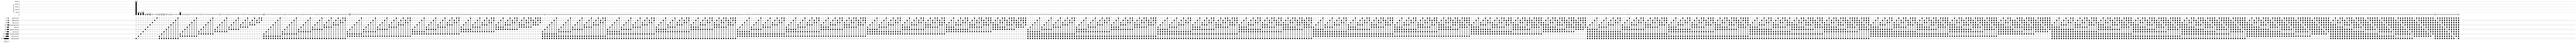

In [34]:
opposition_followers = {k:set(v) for k,v in opposition_followers.items()}
intersections = intersect_followers(opposition_followers)
setplot(intersections, show_percentages = True)
plt.show() #large plot but can be scrolled

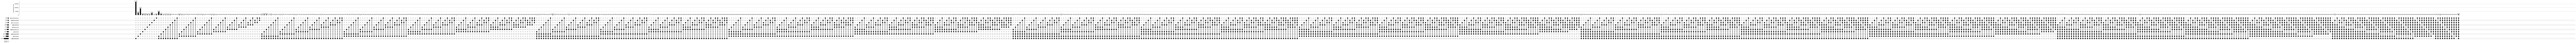

In [37]:
%matplotlib inline
government_followers = {k:set(v) for k,v in government_followers.items()}
intersections = intersect_followers(government_followers)
setplot(intersections, show_percentages = True)
plt.show() #large plot but can be scrolled

#### Get size of the union of all the profiles for each party:

In [38]:
government_superset = list(set(itertools.chain.from_iterable(government_followers.values())))
government_subsets = list(government_followers.values())
opposition_superset = list(set(itertools.chain.from_iterable(opposition_followers.values())))
opposition_subsets = list(opposition_followers.values())

In [39]:
print("Number of government followers {}. Number of opposition followers {}".format(len(government_superset), len(opposition_superset)))

Number of government followers 675773. Number of opposition followers 686198


#### Get intersections of follower IDs, i.e. users who follow more than 6 or more from one party, and not more than 4 from the other:

In [24]:
PATH_GOV = os.path.join(PATH_SAMPLE, 'gov_partisans.p')
PATH_OPP = os.path.join(PATH_SAMPLE, 'opp_partisans.p')
if os.path.isfile(PATH_GOV) and os.path.isfile(PATH_OPP):
    gov_partisans = pickle.load(open(PATH_GOV,'rb'))
    opp_partisans = pickle.load(open(PATH_OPP,'rb'))
else:
    gov_partisans, opp_partisans = subset_followers(government_followers, opposition_followers, 6, 4)
    pickle.dump(gov_partisans,open(PATH_GOV,"wb"))
    pickle.dump(opp_partisans,open(PATH_OPP,"wb"))

In [25]:
print("Total: {} government partisans and {} opposition partisans were filtered".format(len(gov_partisans),len(opp_partisans)))

Total: 35422 government partisans and 26465 opposition partisans were filtered


#### Scrape the population data:

In [ ]:
auth = AppAuthHandler(consumer_key, consumer_secret)
api = API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [41]:
cols = ['id_str',
 'followers_count',
 'created_at',
 'location',
 'statuses_count',
 'screen_name',
 'verified',
 'status-created_at']

In [46]:
PATH_GOV = os.path.join(PATH_SAMPLE, 'gov_partisans_info.csv')
PATH_OPP = os.path.join(PATH_SAMPLE, 'opp_partisans_info.csv')
if os.path.isfile(PATH_GOV):
    gov_partisans_info = pd.read_csv(PATH_GOV, index_col=0, usecols=cols, dtype=str)
else:
    gov_partisans_info = get_user_data(gov_partisans, api=api)
    gov_partisans_info.to_csv(PATH_GOV)
    
if os.path.isfile(PATH_OPP):
    opp_partisans_info = pd.read_csv(PATH_OPP, index_col=0, usecols=cols, dtype=str)
else:
    opp_partisans_info = get_user_data(opp_partisans, api=api)

    opp_partisans_info.to_csv(PATH_OPP)

gov_partisans_info["party"] = "government"
opp_partisans_info["party"] = "opposition"
partisans = pd.concat([gov_partisans_info,opp_partisans_info], axis=0).reset_index()
partisans.head()

,id_str,screen_name,location,followers_count,created_at,verified,statuses_count,status-created_at,party
0,858408039895924736,Marek02189962,"Płock, Polska",2,Sat Apr 29 19:49:59 +0000 2017,False,1,Sat Apr 29 20:19:28 +0000 2017,government
1,901537783654776832,ryszard_oledzki,NaN,4,Sat Aug 26 20:12:12 +0000 2017,False,0,NaN,government
2,1241450557744742402,CollegiumHuman2,"Warszawa, Polska",14,Sat Mar 21 19:44:21 +0000 2020,False,36,Thu Apr 02 09:56:38 +0000 2020,government
3,1240678230866132994,Piotr37403464,NaN,40,Thu Mar 19 16:35:26 +0000 2020,False,348,Sat Mar 21 10:51:36 +0000 2020,government
4,1240318981988286466,Zbignie19217489,NaN,12,Wed Mar 18 16:48:20 +0000 2020,False,469,Thu Apr 02 11:45:51 +0000 2020,government


#### Deal with corrupt cases that resulted from some errors in merging the data:

In [44]:
# coerce numeric to string and remove decimal 0 from floats
partisans[["id_str","statuses_count","followers_count"]] = partisans[["id_str","statuses_count","followers_count"]].applymap(lambda x: str(x).split('.')[0])
# mark numeric vars:
numeric = partisans[["id_str","statuses_count","followers_count"]].applymap(lambda x: x.isnumeric())
# replace non-numeric with nas:
partisans[["id_str","statuses_count","followers_count"]] = partisans[["id_str","statuses_count","followers_count"]].where(numeric)

#### Print corrupt cases:

In [45]:
nas = partisans[["id_str","statuses_count","followers_count"]].applymap(lambda x: pd.isna(x)).sum(axis=1) > 0
partisans.loc[nas].head()

,id_str,screen_name,location,followers_count,created_at,verified,statuses_count,status-created_at,party
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,government
1865,NaN,[],"[{'url': 'https://t.co/5SOMCrfPuc', 'expanded_...",NaN,False,NaN,NaN,https://abs.twimg.com/sticky/default_profile_i...,government
6485,3334104364,steto_tomasz,NaN,NaN,NaN,NaN,NaN,NaN,government
6486,NaN,170,663,NaN,[],NaN,NaN,NaN,government
21154,4707795327,bozkagrabna,Wrocław,NaN,NaN,NaN,NaN,NaN,government


#### Drop corrupt cases:

In [39]:
partisans = partisans.dropna(subset = ["id_str","statuses_count","followers_count"])
partisans[["statuses_count","followers_count"]] = partisans[["statuses_count","followers_count"]].astype(np.int64)

#### Convert dates:

In [30]:
partisans.created_at = pd.to_datetime(partisans.created_at,format='%a %b %d %H:%M:%S +0000 %Y')
partisans["status-created_at"] = pd.to_datetime(partisans["status-created_at"], format='%a %b %d %H:%M:%S +0000 %Y')

Filter out users who tweeted since march 2020:

In [38]:
partisans = partisans[partisans["status-created_at"] >= datetime.datetime.strptime("03/2020","%m/%Y")]
print(f'Active in March: {(partisans["party"] == "government").sum()} government \\
partisans and {(partisans["party"] == "opposition").sum()} opposition partisans')

Active in March: 15300 government partisans and 10578 opposition partisans


Shuffle and sample 5000:

In [81]:
partisans = partisans.iloc[np.random.choice(np.arange(partisans.shape[0]), partisans.shape[0], replace = False)]

In [82]:
PATH_GOV = os.path.join(PATH_SAMPLE, 'gov_sample.p')
PATH_OPP = os.path.join(PATH_SAMPLE, 'opp_sample.p')
if os.path.isfile(PATH_GOV):
    gov_ids = pickle.load(open(PATH_GOV,"rb"))
else:
    gov_ids = partisans[partisans.party == "government"].id_str.astype("str").tolist()
    gov_ids = gov_ids[:5000]
    pickle.dump(gov_ids, open(PATH_GOV,"wb"))
    
if os.path.isfile(PATH_OPP):
    opp_ids = pickle.load(open(PATH_OPP,"rb"))
else:
    opp_ids = partisans[partisans.party == "opposition"].id_str.astype("str").tolist()
    opp_ids = opp_ids[:5000]
    pickle.dump(opp_ids, open(PATH_OPP,"wb"))